## Hello everyone!
### In this kernel I am going to present full process of EDA for FIFA 2019 dataset. The main interesting feature of this kernel is visualization of the football field. And as the result of kernel we will build the model to predict transfer value for players.

<center><img src="https://www.fifplay.com/img/public/fifa-2019.jpg"></center>

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:purple; border:0; color:white' role="tab" aria-controls="home"><center>Quick navigation</center></h3>

* [1. Basic Data Analysis](#1)
* [2. Geo visualization](#2)
* [3. Visualization of the football field](#3)
* [4. Modeling](#4)
    
#### Build your best team for this dataset using genetic algorithms here: <a href="https://www.kaggle.com/isaienkov/find-your-best-team-using-genetic-algorithms">Find your best team using genetic algorithms</a>.
    
#### You can also check another my kernel about sport analytics:  <a href="https://www.kaggle.com/isaienkov/nba-2k20-data-analysis-visualization">NBA 2k20. Data analysis & visualization</a>. There you can find analysis and visualization of NBA 2k20 dataset.

In [1]:
import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.manifold import TSNE

import lightgbm as lgb

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px

from iso3166 import countries
import matplotlib.pyplot as plt

<a id="1"></a>
<h2 style='background:purple; border:0; color:white'><center>1. Basic Data Analysis</center><h2>

In this section we will do a quick look through the data, see some plots and check some dependencies.

In [2]:
SCATTER_SIZE = 800

In [3]:
df = pd.read_csv('/kaggle/input/fifa19/data.csv')
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


NaNs percent for every column.

In [4]:
missed = pd.DataFrame()
missed['column'] = df.columns

missed['percent'] = [
    round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns
]
missed = missed[missed['percent']>0].sort_values('percent')

fig = px.bar(
    missed, 
    x='percent',
    y="column", 
    orientation='h', 
    title='Missed values percent for every column (percent > 0)', 
    height=1300, 
    width=800
)

fig.show()

In [5]:
data = df['Club'].value_counts().reset_index()

data.columns = [
    'club', 
    'count'
]

data = data.sort_values('count')

fig = px.bar(
    data.tail(50), 
    x='count',
    y="club", 
    orientation='h', 
    title='Top 50 teams by number of players', 
    height=900, 
    width=800
)

fig.show()

In [6]:
data = df['Club'].value_counts().reset_index()

data.columns = [
    'club', 
    'count'
]

data = data.sort_values('count')

fig = px.bar(
    data.head(50), 
    x='count',
    y="club", 
    orientation='h', 
    title='Top 50 teams with less number of players', 
    height=900, 
    width=800
)

fig.show()

In [7]:
df.describe()

,Unnamed: 0,ID,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18147.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,9103.000000,214298.338606,25.122206,66.238699,71.307299,1597.809908,1.113222,2.947299,2.361308,19.546096,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,5256.052511,29965.244204,4.669943,6.908930,6.136496,272.586016,0.394031,0.660456,0.756164,15.947765,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,0.000000,16.000000,16.000000,46.000000,48.000000,731.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4551.500000,200315.500000,21.000000,62.000000,67.000000,1457.000000,1.000000,3.000000,2.000000,8.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,9103.000000,221759.000000,25.000000,66.000000,71.000000,1635.000000,1.000000,3.000000,2.000000,17.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,13654.500000,236529.500000,28.000000,71.000000,75.000000,1787.000000,1.000000,3.000000,3.000000,26.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,18206.000000,246620.000000,45.000000,94.000000,95.000000,2346.000000,5.000000,5.000000,5.000000,99.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


Let's define functions to plot different kinds of charts.

In [8]:
def plot_bar_plot(data, categorical_feature, target_feature, orientation, title, top_records=None, sort=False):
    data = data.groupby(categorical_feature)[target_feature].count().reset_index()
    fig = px.bar(
        data, 
        x=categorical_feature, 
        y=target_feature, 
        orientation=orientation, 
        title=title,
        height=600,
        width=800
    )
    fig.show()
    
def plot_pie_count(data, field="Nationality", percent_limit=0.5, title="Number of players by "):
    
    title += field
    data[field] = data[field].fillna('NA')
    data = data[field].value_counts().to_frame()

    total = data[field].sum()
    data['percentage'] = 100 * data[field]/total    

    percent_limit = percent_limit
    otherdata = data[data['percentage'] < percent_limit] 
    others = otherdata['percentage'].sum()  
    maindata = data[data['percentage'] >= percent_limit]

    data = maindata
    other_label = "Others(<" + str(percent_limit) + "% each)"
    data.loc[other_label] = pd.Series({field:otherdata[field].sum()}) 
    
    labels = data.index.tolist()   
    datavals = data[field].tolist()
    
    trace=go.Pie(
        labels=labels,
        values=datavals
    )

    layout = go.Layout(
        title = title,
        height=500,
        width=800
    )
    
    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig)

In [9]:
plot_bar_plot(
    df, 
    'Position', 
    'Value', 
    'v', 
    'Number of players by position'
)

As we can see the most players are on positions `ST`, `GK` and `CB`.

In [10]:
df[df['Position']=='ST'].head(10)

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
10,10,188545,R. Lewandowski,29,https://cdn.sofifa.org/players/4/19/188545.png,Poland,https://cdn.sofifa.org/flags/37.png,90,90,FC Bayern München,...,86.0,34.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0,€127.1M
16,16,202126,H. Kane,24,https://cdn.sofifa.org/players/4/19/202126.png,England,https://cdn.sofifa.org/flags/14.png,89,91,Tottenham Hotspur,...,89.0,56.0,36.0,38.0,8.0,10.0,11.0,14.0,11.0,€160.7M
23,23,153079,S. Agüero,30,https://cdn.sofifa.org/players/4/19/153079.png,Argentina,https://cdn.sofifa.org/flags/52.png,89,89,Manchester City,...,90.0,30.0,20.0,12.0,13.0,15.0,6.0,11.0,14.0,€119.3M
36,36,173731,G. Bale,28,https://cdn.sofifa.org/players/4/19/173731.png,Wales,https://cdn.sofifa.org/flags/50.png,88,88,Real Madrid,...,86.0,54.0,55.0,52.0,15.0,15.0,11.0,5.0,6.0,€123M
43,43,201399,M. Icardi,25,https://cdn.sofifa.org/players/4/19/201399.png,Argentina,https://cdn.sofifa.org/flags/52.png,87,90,Inter,...,85.0,45.0,24.0,20.0,13.0,9.0,5.0,7.0,9.0,€114.5M
47,47,192505,R. Lukaku,25,https://cdn.sofifa.org/players/4/19/192505.png,Belgium,https://cdn.sofifa.org/flags/7.png,87,89,Manchester United,...,83.0,30.0,30.0,30.0,8.0,15.0,14.0,7.0,10.0,€120.3M
48,48,192387,C. Immobile,28,https://cdn.sofifa.org/players/4/19/192387.png,Italy,https://cdn.sofifa.org/flags/27.png,87,87,Lazio,...,81.0,34.0,33.0,32.0,6.0,8.0,15.0,12.0,6.0,€88.4M
87,87,193301,A. Lacazette,27,https://cdn.sofifa.org/players/4/19/193301.png,France,https://cdn.sofifa.org/flags/18.png,85,86,Arsenal,...,85.0,29.0,42.0,30.0,11.0,6.0,9.0,5.0,6.0,€88.9M
98,98,180930,E. Džeko,32,https://cdn.sofifa.org/players/4/19/180930.png,Bosnia Herzegovina,https://cdn.sofifa.org/flags/8.png,85,85,Roma,...,83.0,58.0,28.0,16.0,9.0,11.0,13.0,15.0,15.0,€51.9M


Now we will define categorical features that can be used in supervised modeling.

In [11]:
categorical = [
    'Nationality', 
    'Club', 
    'Preferred Foot',
    'Work Rate', 
    'Body Type', 
    'Position'
]

Number of players for each categorical variable.

In [12]:
plot_pie_count(df, 'Nationality')
plot_pie_count(df, 'Preferred Foot')
plot_pie_count(df, 'Work Rate', 0.1)
plot_pie_count(df, 'Body Type', 0.1)

Let's convert `Value` column to float type.

In [13]:
df['Value'] = df['Value'].str.replace('€','').str.replace('M',' 1000000').str.replace('K',' 1000')
df['Value'] = df['Value'].str.split(' ', expand=True)[0].astype(float) * df['Value'].str.split(' ', expand=True)[1].astype(float)
df['Value'] = df['Value'].fillna(0).astype(np.float32)

In [14]:
body_dict = {
    'PLAYER_BODY_TYPE_25' : np.nan,
    'Messi' : np.nan,
    'Shaqiri': np.nan,
    'Neymar': np.nan,
    'Akinfenwa': np.nan,
    'C. Ronaldo': np.nan,
    'Courtois': np.nan
}

df['Body Type'] = df['Body Type'].replace(body_dict)
df['Height'] = df['Height'].str.replace("'",".").astype(float)
df['Weight'] = df['Weight'].str.replace("lbs","").astype(float)

In [15]:
fig = px.scatter(
    df, 
    x='Overall', 
    y='Value', 
    height=SCATTER_SIZE,
    width=SCATTER_SIZE,
    title='Scatter plot for Value and Overall' 
)

fig.show()

Top 20 players with the highest Value.

In [16]:
df.sort_values("Value", ascending=False)[['Name', "Age", "Value", "Overall"]].head(20)

,Name,Age,Value,Overall
2,Neymar Jr,26,118500000.0,92
0,L. Messi,31,110500000.0,94
4,K. De Bruyne,27,102000000.0,91
5,E. Hazard,27,93000000.0,91
15,P. Dybala,24,89000000.0,89
16,H. Kane,24,83500000.0,89
25,K. Mbappé,19,81000000.0,88
7,L. Suárez,31,80000000.0,91
17,A. Griezmann,27,78000000.0,89
10,R. Lewandowski,29,77000000.0,90


In [17]:
fig = px.scatter(
    df, 
    x='Age', 
    y='Overall', 
    height=SCATTER_SIZE,
    width=SCATTER_SIZE,
    title='Scatter plot for Age and Overall' 
)

fig.show()

In [18]:
fig = px.scatter(
    df, 
    x='Age', 
    y='Potential', 
    height=SCATTER_SIZE,
    width=SCATTER_SIZE,
    title='Scatter plot for Age and Potential' 
)

fig.show()

In [19]:
fig = px.scatter(
    df, 
    x='Potential', 
    y='Overall', 
    height=SCATTER_SIZE,
    width=SCATTER_SIZE,
    title='Scatter plot for Potential and Overall' 
)

fig.show()

Top 20 players by potential.

In [20]:
df.sort_values("Potential", ascending=False)[['Name', "Age", "Value", "Overall", 'Potential']].head(20)

,Name,Age,Value,Overall,Potential
25,K. Mbappé,19,81000000.0,88,95
0,L. Messi,31,110500000.0,94,94
15,P. Dybala,24,89000000.0,89,94
1,Cristiano Ronaldo,33,77000000.0,94,94
2,Neymar Jr,26,118500000.0,92,93
3,De Gea,27,72000000.0,91,93
9,J. Oblak,25,68000000.0,90,93
229,G. Donnarumma,19,29000000.0,82,93
1143,Vinícius Júnior,17,17500000.0,77,92
155,O. Dembélé,21,40000000.0,83,92


Let's check the `Value` columns distribution. As we can see the majority of players value is less than 5M euro. 

In [21]:
fig = px.histogram(
    df, 
    "Value", 
    nbins=100, 
    title='Value distribution',
    width=800,
    height=600
)

fig.show()

Now we will see what is the avarage value for every age in the dataset. As we can see from plot the most suitable age to get high transfer value is 27 years.

In [22]:
age = df.groupby('Age')['Value'].mean().reset_index()

fig = px.bar(
    age, 
    x="Age", 
    y="Value", 
    orientation='v', 
    title='Mean Value by Age'
)

fig.show()

In [23]:
df.sort_values("Age", ascending=False)[['Name', "Age", "Value", "Overall"]].head(20)

,Name,Age,Value,Overall
4741,O. Pérez,45,160000.0,71
18183,K. Pilkington,44,0.0,48
17726,T. Warner,44,0.0,53
10545,S. Narazaki,42,40000.0,65
7225,C. Muñoz,41,60000.0,68
1120,J. Villar,41,0.0,77
12192,H. Sulaimani,41,0.0,63
15426,M. Tyler,41,10000.0,59
4228,B. Nivet,41,0.0,71
10356,F. Kippe,40,0.0,65


In [24]:
fig = px.histogram(
    df, 
    "Age", 
    nbins=50, 
    title='Age distribution'
)

fig.show()

Top 50 teams with highest player's average Value.

In [25]:
club = df.groupby('Club')['Value'].mean().reset_index().sort_values('Value', ascending=True).tail(50)

fig = px.bar(
    club, 
    x="Value", 
    y="Club", 
    orientation='h', 
    width=800, 
    height=900
)

fig.show()

Top 50 teams with highest player's average Overall rating.

In [26]:
club = df.groupby('Club')['Overall'].mean().reset_index().sort_values('Overall', ascending=True).tail(50)

fig = px.bar(
    club, 
    x="Overall", 
    y="Club", 
    orientation='h',
    title="Top 50 teams with highest player's average Overall rating",
    width=800,
    height=900
)

fig.show()

Top 40 Nationalities by max rating for a single player.

In [27]:
club = df.groupby('Nationality')['Overall'].max().reset_index().sort_values('Overall', ascending=True).tail(40)

fig = px.bar(
    club, 
    x="Overall", 
    y="Nationality", 
    orientation='h',
    width=800,
    height=800
)

fig.show()

In [28]:
club = df.groupby('Nationality')['Overall'].mean().reset_index().sort_values('Overall', ascending=True).tail(40)

fig = px.bar(
    club, 
    x="Overall", 
    y="Nationality", 
    orientation='h', 
    title="Top 40 countries with highest player's average Overall rating",
    width=800,
    height=800
)

fig.show()

In [29]:
club = df.groupby('Nationality')['Value'].mean().reset_index().sort_values('Value', ascending=True).tail(40)

fig = px.bar(
    club, 
    x="Value", 
    y="Nationality", 
    orientation='h', 
    title="Top 40 countries with highest player's average Value",
    width=800,
    height=800
)

fig.show()

<a id="2"></a>
<h2 style='background:purple; border:0; color:white'><center>2. Geo visualization</center><h2>

In [30]:
country_dict = {}
for c in countries:
    country_dict[c.name] = c.alpha3
    
df['alpha3'] = df['Nationality']
df = df.replace(
    {
        "alpha3": country_dict
    }
)

gbr = [
    'England', 
    'Wales', 
    'Scotland', 
    'Northern Ireland'
]

df.loc[df['Nationality'].isin(gbr), 'alpha3'] = 'GBR'
df.loc[df['Nationality'] == 'Bosnia Herzegovina', 'alpha3'] = 'BIH'
df.loc[df['Nationality'] == 'Korea Republic', 'alpha3'] = 'KOR'
df.loc[df['Nationality'] == 'Czech Republic', 'alpha3'] = 'CZE'
df.loc[df['Nationality'] == 'St Lucia', 'alpha3'] = 'LCA'
df.loc[df['Nationality'] == 'Palestine', 'alpha3'] = 'PSE'
df.loc[df['Nationality'] == 'Antigua & Barbuda', 'alpha3'] = 'ATG'
df.loc[df['Nationality'] == 'St Kitts Nevis', 'alpha3'] = 'KNA'
df.loc[df['Nationality'] == 'Korea DPR', 'alpha3'] = 'PRK'
df.loc[df['Nationality'] == 'São Tomé & Príncipe', 'alpha3'] = 'STP'
df.loc[df['Nationality'] == 'Trinidad & Tobago', 'alpha3'] = 'TTO'
df.loc[df['Nationality'] == 'Bolivia', 'alpha3'] = 'BOL'
df.loc[df['Nationality'] == 'Moldova', 'alpha3'] = 'MDA'
df.loc[df['Nationality'] == 'Curacao', 'alpha3'] = 'CUW'
df.loc[df['Nationality'] == 'Tanzania', 'alpha3'] = 'TZA'
df.loc[df['Nationality'] == 'Guinea Bissau', 'alpha3'] = 'GNB'
df.loc[df['Nationality'] == 'China PR', 'alpha3'] = 'CHN'
df.loc[df['Nationality'] == 'FYR Macedonia', 'alpha3'] = 'MKD'
df.loc[df['Nationality'] == 'Iran', 'alpha3'] = 'IRN'
df.loc[df['Nationality'] == 'Syria', 'alpha3'] = 'SYR'
df.loc[df['Nationality'] == 'Cape Verde', 'alpha3'] = 'CPV'
df.loc[df['Nationality'] == 'United States', 'alpha3'] = 'USA'
df.loc[df['Nationality'] == 'Republic of Ireland', 'alpha3'] = 'IRL'
df.loc[df['Nationality'] == 'Venezuela', 'alpha3'] = 'VEN'
df.loc[df['Nationality'] == 'Russia', 'alpha3'] = 'RUS'
df.loc[df['Nationality'] == 'Ivory Coast', 'alpha3'] = 'CIV'
df.loc[df['Nationality'] == 'DR Congo', 'alpha3'] = 'COD'
df.loc[df['Nationality'] == 'Central African Rep.', 'alpha3'] = 'CAF'

In [31]:
data = df.groupby(['alpha3', 'Nationality'])['Name'].count().reset_index()

data.columns = [
    'alpha3', 
    'nationality', 
    'count'
]

fig = px.choropleth(
    data, 
    locations="alpha3",
    hover_name='nationality',
    color='count',
    projection="natural earth",
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Number of players from every country',
    width=800, 
    height=700
)

fig.show()

In [32]:
data = df.groupby(['alpha3', 'Nationality'])['Overall'].max().reset_index()

data.columns = [
    'alpha3', 
    'nationality', 
    'max_rating'
]

fig = px.choropleth(
    data, 
    locations="alpha3",
    hover_name='nationality',
    color="max_rating",
    projection="natural earth",
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Max rating for every country',
    width=800, 
    height=700
)

fig.show()

In [33]:
data = df.groupby(['alpha3', 'Nationality'])['Age'].max().reset_index()

data.columns = [
    'alpha3', 
    'nationality', 
    'max_age'
]

fig = px.choropleth(
    data, 
    locations="alpha3",
    hover_name='nationality',
    color="max_age",
    projection="natural earth",
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Max age of sportsman for every country',
    width=800, 
    height=700
)

fig.show()

In [34]:
data = df.groupby(['alpha3', 'Nationality'])['Value'].max().reset_index()

data.columns = [
    'alpha3', 
    'nationality', 
    'max_value'
]

fig = px.choropleth(
    data, 
    locations="alpha3",
    hover_name='nationality',
    color="max_value",
    projection="natural earth",
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Max Value of sportsman for every country',
    width=800, 
    height=700
)

fig.show()

In [35]:
data = df['alpha3'].value_counts().reset_index()

data.columns=[
    'alpha3', 
    'national_count'
]

df = pd.merge(df, data, on='alpha3')
data = df[df['national_count']>=50]
df = df.drop(['national_count'], axis=1)
data = data.groupby(['alpha3', 'Nationality'])['Overall'].mean().reset_index()
data.columns = [
    'alpha3', 
    'nationality', 
    'mean_rating'
]

fig = px.choropleth(
    data, 
    locations="alpha3",
    hover_name='nationality',
    color="mean_rating",
    projection="natural earth",
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Mean rating for sportsmen for every country (minimum 50 players)',
    width=800, 
    height=700
)

fig.show()

<a id="3"></a>
<h2 style='background:purple; border:0; color:white'><center>3. Visualization of the football field</center><h2>

In [36]:
def draw_pitch(pitch, line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if view.lower().startswith("h"):
        fig,ax = plt.subplots(figsize=(20.8, 13.6))
        plt.ylim(98, 210)
        plt.xlim(-2, 138)
    else:
        fig,ax = plt.subplots(figsize=(13.6, 20.8))
        plt.ylim(-2, 210)
        plt.xlim(-2, 138)
    ax.axis('off')

    # side and goal lines
    lx1 = [0, 0, 136, 136, 0]
    ly1 = [0, 208, 208, 0, 0]

    plt.plot(lx1,ly1,color=line,zorder=5)

    # boxes, 6 yard box and goals
    # outer boxes
    lx2 = [27.68, 27.68, 108.32, 108.32] 
    ly2 = [208, 175, 175, 208]
    plt.plot(lx2,ly2,color=line,zorder=5)

    lx3 = [27.68, 27.68, 108.32, 108.32] 
    ly3 = [0, 33, 33, 0]
    plt.plot(lx3,ly3,color=line,zorder=5)

    # goals
    lx4 = [60.68, 60.68, 75.32, 75.32]
    ly4 = [208, 208.4, 208.4, 208]
    plt.plot(lx4,ly4,color=line,zorder=5)

    lx5 = [60.68, 60.68, 75.32, 75.32]
    ly5 = [0, -0.4, -0.4, 0]
    plt.plot(lx5,ly5,color=line,zorder=5)

    # 6 yard boxes
    lx6 = [49.68, 49.68, 86.32, 86.32]
    ly6 = [208, 199, 199, 208]
    plt.plot(lx6,ly6,color=line,zorder=5)

    lx7 = [49.68, 49.68, 86.32, 86.32]
    ly7 = [0, 9, 9, 0]
    plt.plot(lx7,ly7,color=line,zorder=5)

    # Halfway line, penalty spots, and kickoff spot
    lx8 = [0, 136] 
    ly8 = [104, 104]
    plt.plot(lx8,ly8,color=line,zorder=5)

    plt.scatter(68, 186, color=line, zorder=5)
    plt.scatter(68, 22, color=line, zorder=5)
    plt.scatter(68, 104, color=line, zorder=5)

    circle1 = plt.Circle((68, 187), 18.30, ls='solid', lw=3, color=line, fill=False, zorder=1, alpha=1)
    circle2 = plt.Circle((68, 21), 18.30, ls='solid', lw=3, color=line, fill=False, zorder=1, alpha=1)
    circle3 = plt.Circle((68, 104), 18.30, ls='solid', lw=3, color=line, fill=False, zorder=2, alpha=1)

    rec1 = plt.Rectangle((40, 175), 60, 33, ls='-', color=pitch, zorder=1, alpha=1)
    rec2 = plt.Rectangle((40, 0), 60, 33, ls='-', color=pitch, zorder=1, alpha=1)
    rec3 = plt.Rectangle((-1, -1), 140, 212, ls='-', color=pitch, zorder=1, alpha=1)

    ax.add_artist(rec3)
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(rec1)
    ax.add_artist(rec2)
    ax.add_artist(circle3)   

Every position at the football field.

In [37]:
x = [
    68, 68, 68, 32, 104, 68, 32, 104, 68, 44, 88, 20, 116, 12, 124, 68, 68, 16, 120, 16, 120, 40, 96, 32, 104, 32, 104
]

y = [
    186, 150, 1, 150, 150, 112, 114, 114, 14, 16, 16, 24, 24, 50, 50, 50, 74, 74, 74, 130, 130, 74, 74, 186, 186, 50, 50
]

n = [
    'ST', 'CF', 'GK', 'LF', 'RF', 'CAM', 'LAM', 'RAM', 'CB', 
    'LCB', 'RCB', 'LB', 'RB', 'LWB', 'RWB', 'CDM', 'CM', 'LM', 
    'RM', 'LW', 'RW', 'LCM', 'RCM', 'LS', 'RS', 'LDM', 'RDM'
]

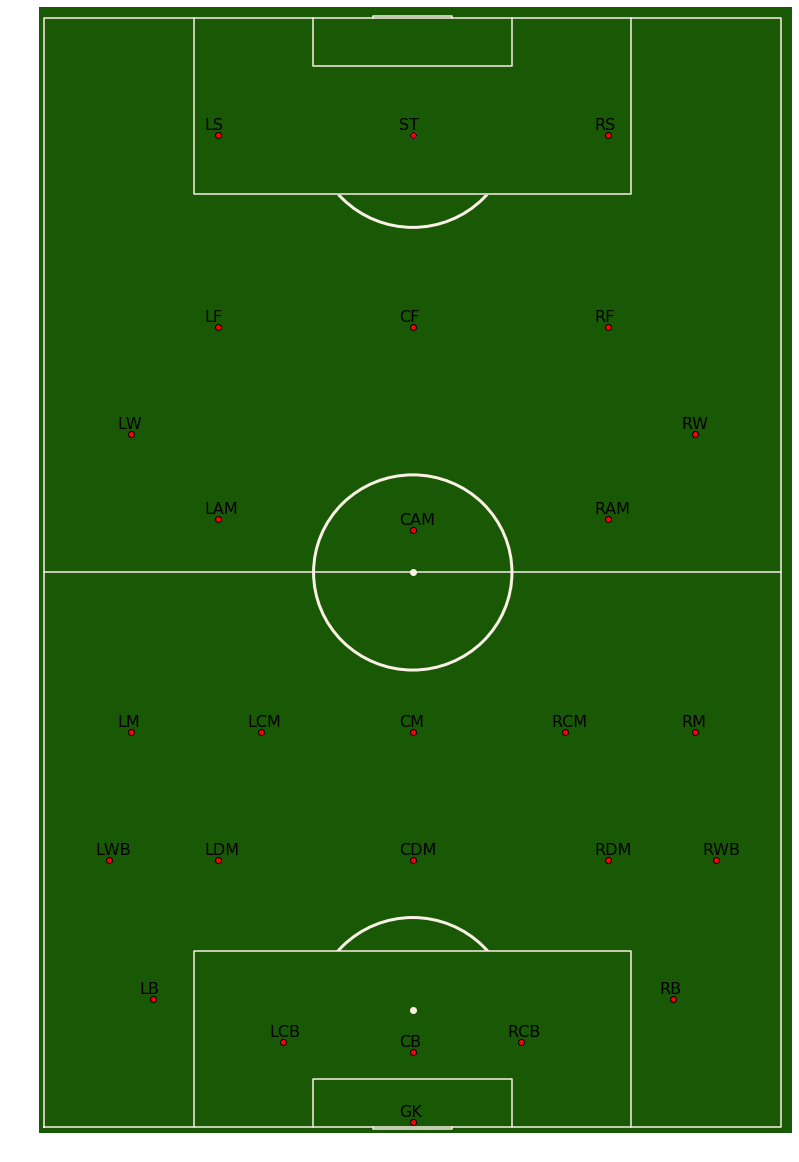

In [38]:
draw_pitch(
    "#195905", 
    "#faf0e6", 
    "v", 
    "full"
)

for i, pos in enumerate(n):
    x_c = x[i]
    y_c = y[i]
    plt.scatter(
        x_c, 
        y_c, 
        marker='o', 
        color='red', 
        edgecolors="black", 
        zorder=10
    )
    plt.text(
        x_c-2.5, 
        y_c+1, 
        pos, 
        fontsize=16
    )

The best team (the best player for every position and his Overall)

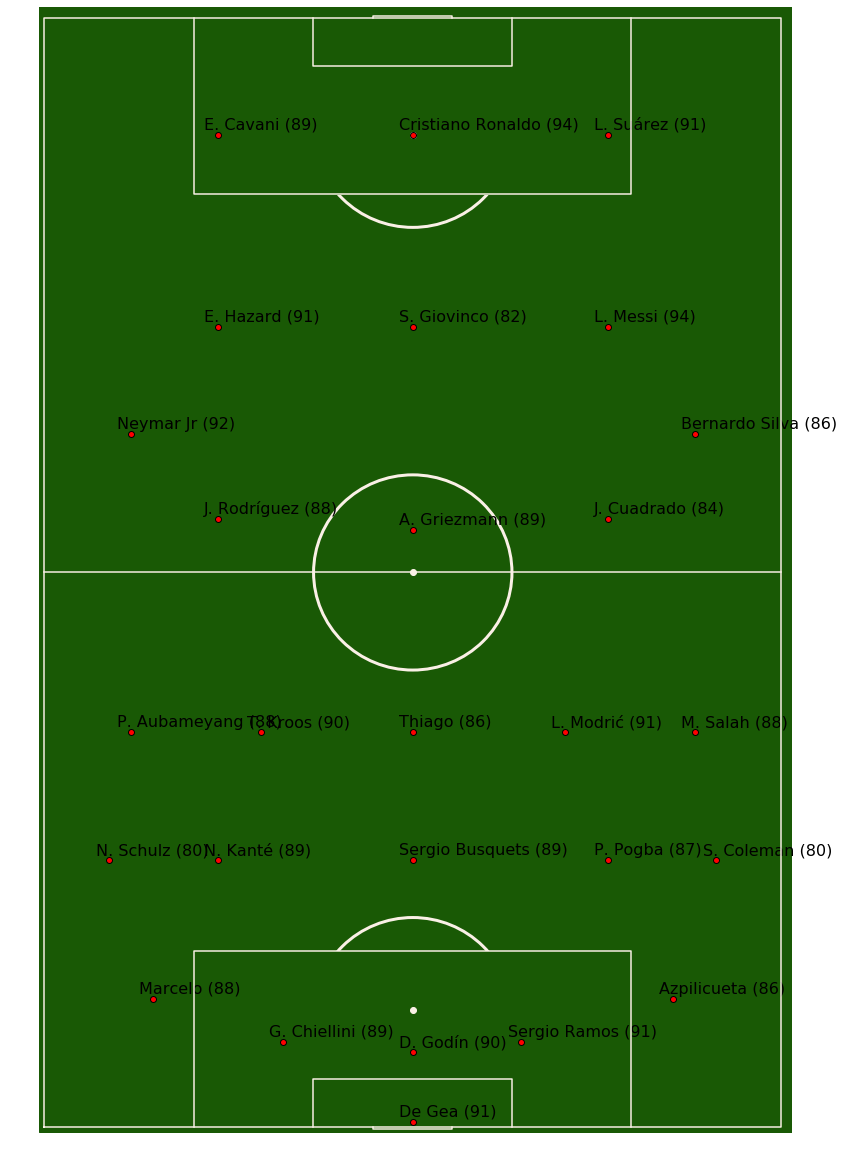

In [39]:
res = list()
for item in n:
    test_df = df[df['Position']==item]
    test_df = test_df.sort_values(['Overall'], ascending=False)
    res.append(test_df.iloc[0]['Name'] + ' (' + str(test_df.iloc[0]['Overall']) + ')')

draw_pitch(
    "#195905", 
    "#faf0e6", 
    "v", 
    "full"
)

for i, pos in enumerate(res):
    x_c = x[i]
    y_c = y[i]
    plt.scatter(
        x_c, 
        y_c, 
        marker='o', 
        color='red', 
        edgecolors="black", 
        zorder=10
    )
    plt.text(
        x_c-2.5, 
        y_c+1, 
        pos, 
        fontsize=16
    )

The most expensive team

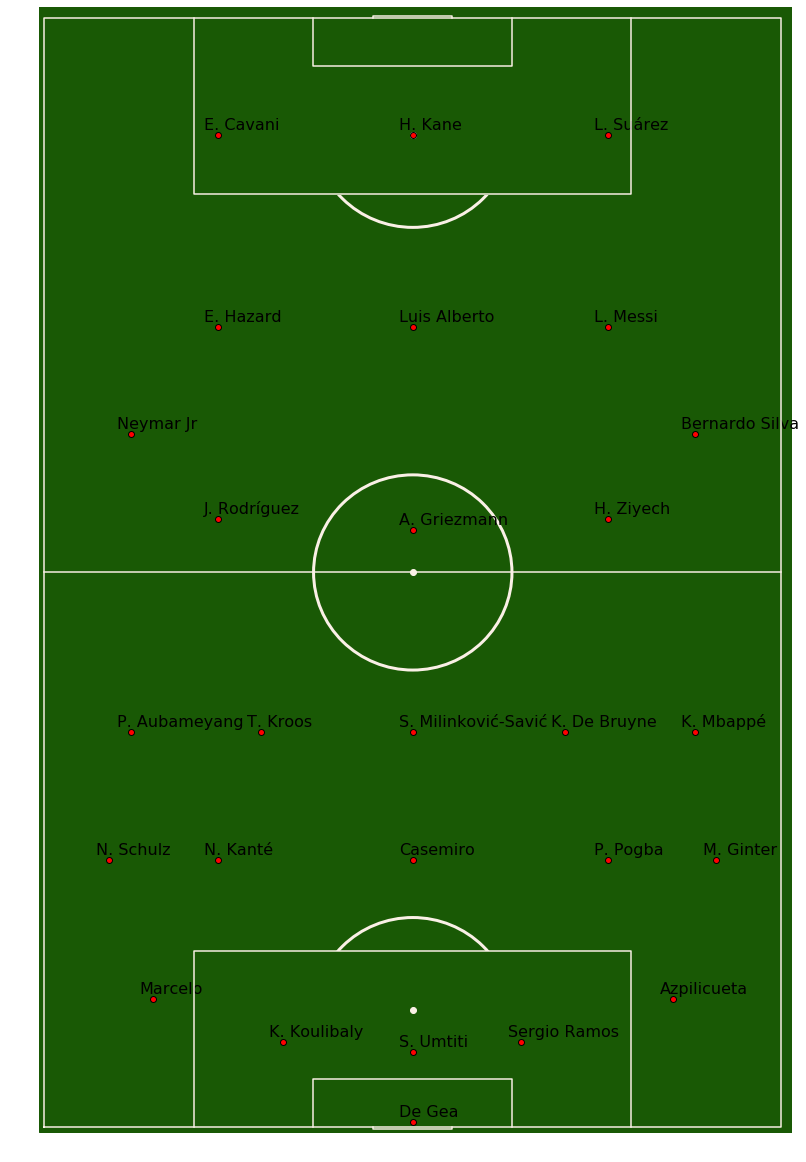

In [40]:
res = list()
for item in n:
    test_df = df[df['Position']==item]
    test_df = test_df.sort_values(['Value'], ascending=False)
    res.append(test_df.iloc[0]['Name'])

draw_pitch(
    "#195905",
    "#faf0e6",
    "v",
    "full"
)

for i, pos in enumerate(res):
    x_c = x[i]
    y_c = y[i]
    plt.scatter(
        x_c, 
        y_c, 
        marker='o', 
        color='red', 
        edgecolors="black", 
        zorder=10
    )
    plt.text(
        x_c-2.5, 
        y_c+1, 
        pos, 
        fontsize=16
    )

The best Ukrainian team

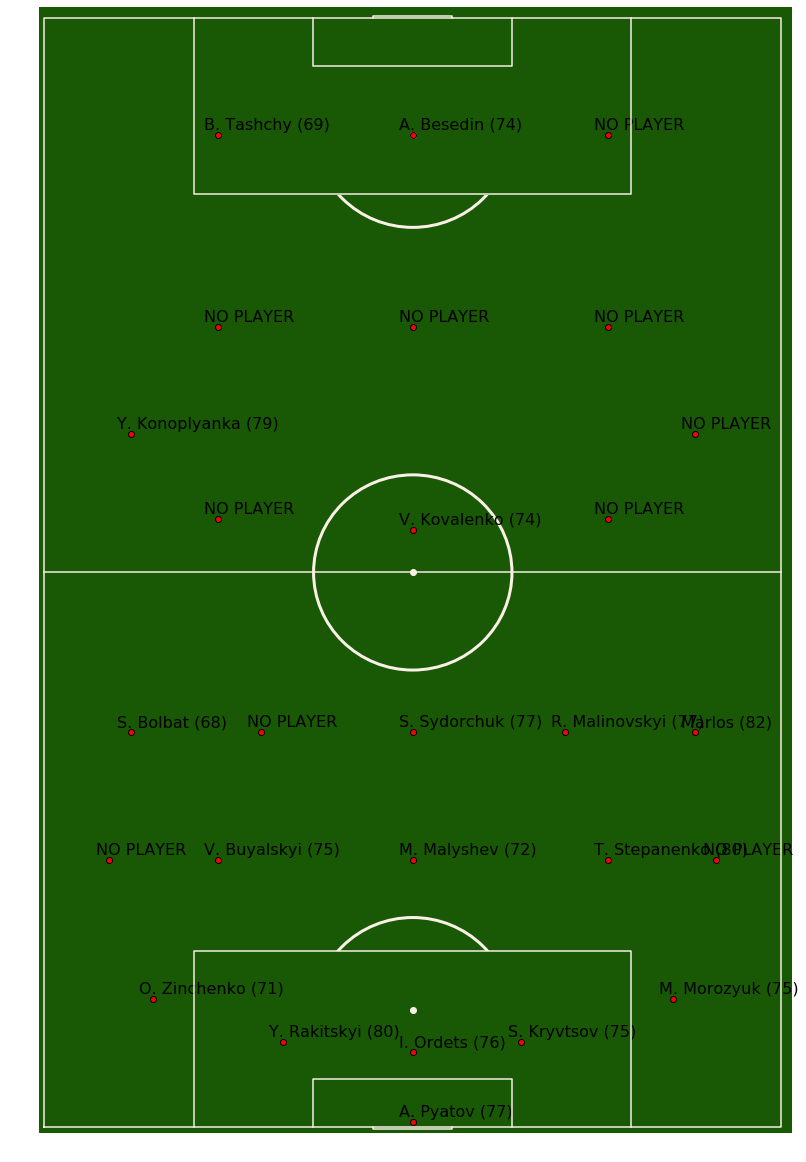

In [41]:
res = list()
for item in n:
    test_df = df[(df['Position']==item) & (df['Nationality']=='Ukraine')]
    test_df = test_df.sort_values(['Overall'], ascending=False)
    if len(test_df) > 0:
        res.append(test_df.iloc[0]['Name'] + ' (' + str(test_df.iloc[0]['Overall']) + ')')
    else:
         res.append('NO PLAYER')   

draw_pitch(
    "#195905",
    "#faf0e6",
    "v",
    "full"
)

for i, pos in enumerate(res):
    x_c = x[i]
    y_c = y[i]
    plt.scatter(
        x_c, 
        y_c, 
        marker='o', 
        color='red', 
        edgecolors="black", 
        zorder=10
    )
    plt.text(
        x_c-2.5, 
        y_c+1, 
        pos, 
        fontsize=16
    )

The best potential team

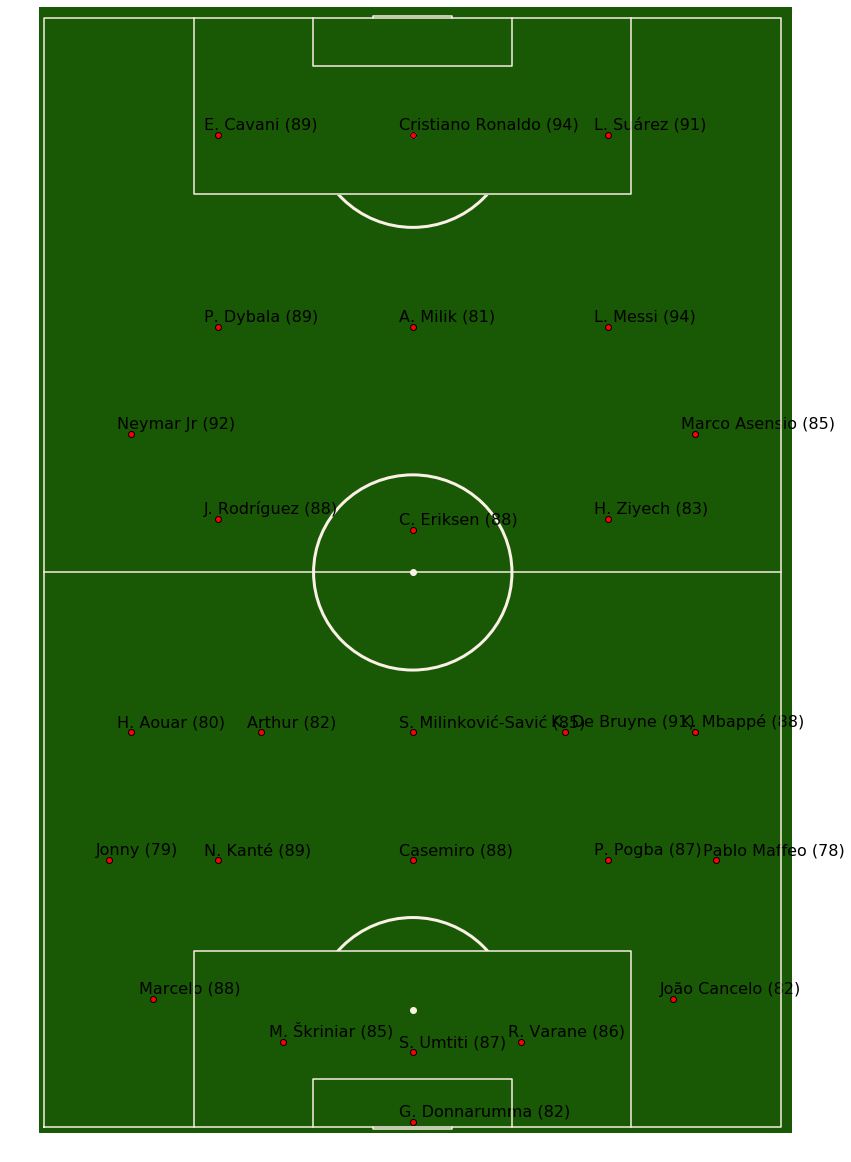

In [42]:
res = list()
for item in n:
    test_df = df[df['Position']==item]
    test_df = test_df.sort_values(['Potential'], ascending=False)
    res.append(test_df.iloc[0]['Name'] + ' (' + str(test_df.iloc[0]['Overall']) + ')')

draw_pitch(
    "#195905",
    "#faf0e6",
    "v",
    "full"
)

for i, pos in enumerate(res):
    x_c = x[i]
    y_c = y[i]
    plt.scatter(
        x_c, 
        y_c, 
        marker='o', 
        color='red', 
        edgecolors="black", 
        zorder=10
    )
    plt.text(
        x_c-2.5, 
        y_c+1, 
        pos, 
        fontsize=16
    )

<a id="4"></a>
<h2 style='background:purple; border:0; color:white'><center>4. Modeling</center><h2>

In [43]:
drop = [
    'Unnamed: 0', 'ID', 'Name', 'Photo', 
    'Flag', 'Potential', 'Club Logo', 'Special', 
    'Real Face', 'Jersey Number',  'Contract Valid Until',  'Release Clause',
    'Wage', 'Joined', 'Loaned From', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 
    'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 
    'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'
]

df = df.drop(drop, axis=1)

In [44]:
for item in categorical:
    df[item] = df[item].fillna('0') 
    le = LabelEncoder()
    df[item] = le.fit_transform(df[item])

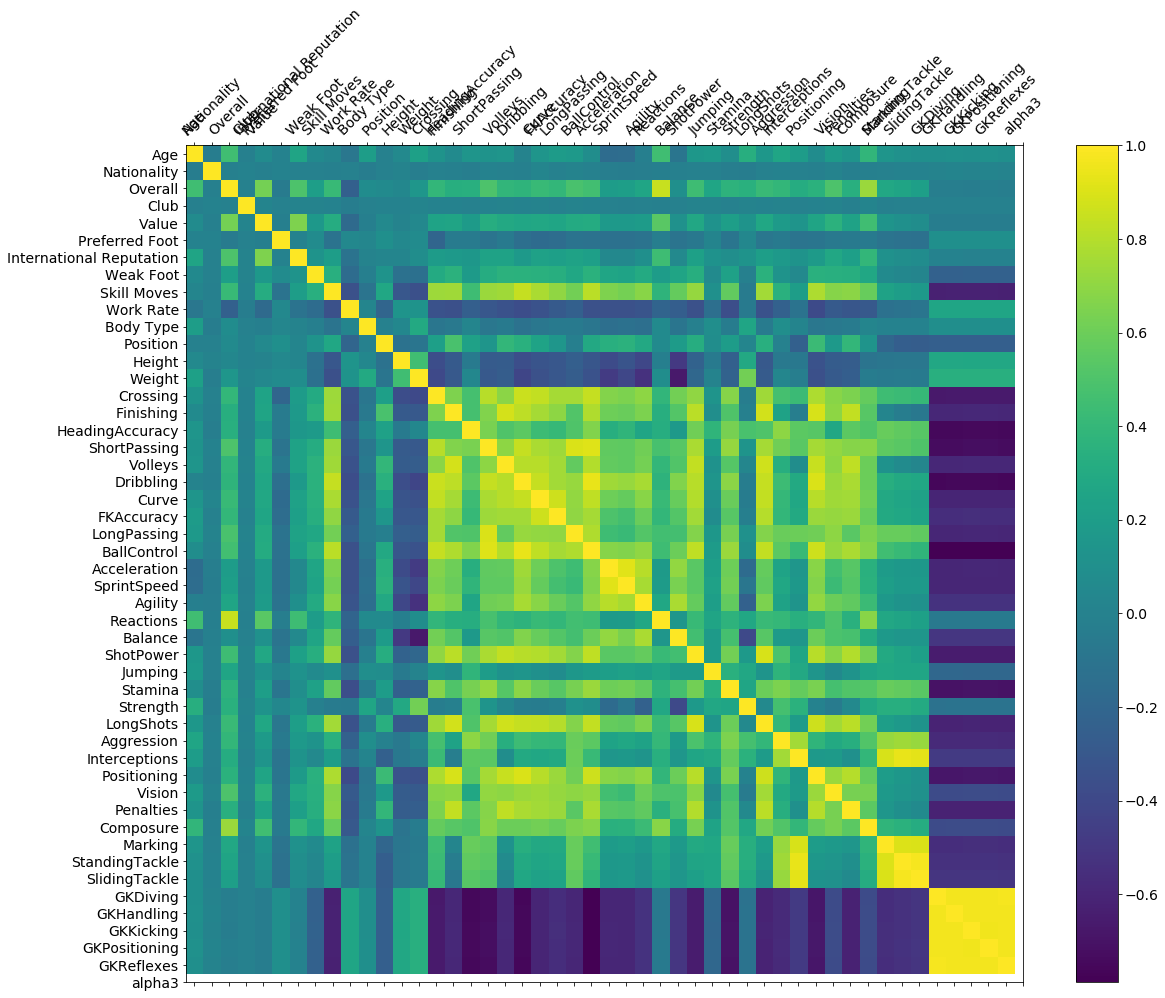

In [45]:
f = plt.figure(
    figsize=(19, 15)
)

plt.matshow(
    df.corr(), 
    fignum=f.number
)

plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

Let's drop weak features.

In [46]:
df

,Age,Nationality,Overall,Club,Value,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,alpha3
0,31,6,94,213,110500000.0,0,5.0,4.0,4.0,8,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,ARG
1,24,6,89,327,89000000.0,0,3.0,3.0,4.0,2,...,84.0,23.0,20.0,20.0,5.0,4.0,4.0,5.0,8.0,ARG
2,30,6,89,375,64500000.0,2,4.0,4.0,4.0,2,...,90.0,30.0,20.0,12.0,13.0,15.0,6.0,11.0,14.0,ARG
3,30,6,88,383,57000000.0,2,4.0,4.0,3.0,2,...,86.0,35.0,22.0,18.0,5.0,12.0,7.0,5.0,10.0,ARG
4,25,6,87,316,64500000.0,2,3.0,4.0,3.0,7,...,85.0,45.0,24.0,20.0,13.0,9.0,5.0,7.0,9.0,ARG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,25,98,61,165,300000.0,0,1.0,3.0,3.0,8,...,45.0,36.0,28.0,29.0,7.0,14.0,11.0,10.0,15.0,MLT
18203,25,14,60,392,250000.0,2,1.0,2.0,2.0,8,...,52.0,53.0,42.0,27.0,6.0,5.0,6.0,10.0,8.0,BLZ
18204,25,138,60,380,260000.0,2,1.0,4.0,2.0,1,...,46.0,22.0,20.0,15.0,9.0,6.0,7.0,10.0,9.0,SSD
18205,17,74,56,356,180000.0,0,1.0,3.0,3.0,8,...,58.0,19.0,47.0,52.0,10.0,13.0,8.0,15.0,9.0,IDN


In [47]:
df = df.drop(['alpha3'], axis=1)
for col in df.columns:
    if abs(df[col].corr(df['Value'])) < 0.15:
        df = df.drop([col], axis=1)

df.columns

Index(['Overall', 'Value', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'ShotPower', 'Stamina', 'LongShots', 'Aggression',
       'Positioning', 'Vision', 'Penalties', 'Composure'],
      dtype='object')

In [48]:
target = np.log1p(df["Value"])
original_target = df['Value']
df = df.drop(['Value'], axis=1)

In [49]:
new_categorical = list()
for item in categorical:
    if item in df.columns:
        new_categorical.append(item)
        
categorical = new_categorical

In [50]:
df = df.fillna(-1)

In [51]:
X_embedded = TSNE(
    n_components=2, 
    random_state=666
).fit_transform(df)

X_embedded = pd.DataFrame(X_embedded)

In [52]:
analysis = pd.DataFrame()
analysis['color'] = df['Overall']
analysis['x'] = X_embedded[0]
analysis['y'] = X_embedded[1]

fig = px.scatter(
    analysis, 
    x='x', 
    y='y', 
    color='color',
    height=800,
    width=800,
    title='TSNE for dataset'
)

fig.show()

In [53]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {
        'rmse'
    },
    'subsample': 0.25,
    'subsample_freq': 1,
    'learning_rate': 0.05,
    'num_leaves': 20,
    'feature_fraction': 0.9
}

folds = 5
seed = 666

kf = KFold(
    n_splits=folds, 
    shuffle=True, 
    random_state=seed
)

models = list()
for train_index, val_index in kf.split(df):
    train_X = df[df.columns].iloc[train_index]
    val_X = df[df.columns].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categorical)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categorical)
    
    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=(lgb_train, lgb_eval),
        early_stopping_rounds=100,
        verbose_eval = 100
    )
    models.append(gbm)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.5085	valid_1's rmse: 1.70548
Early stopping, best iteration is:
[72]	training's rmse: 1.53964	valid_1's rmse: 1.7039
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.51763	valid_1's rmse: 1.66621
Early stopping, best iteration is:
[65]	training's rmse: 1.56006	valid_1's rmse: 1.66135
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.52848	valid_1's rmse: 1.63348
Early stopping, best iteration is:
[69]	training's rmse: 1.56298	valid_1's rmse: 1.62869
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.5193	valid_1's rmse: 1.66435
Early stopping, best iteration is:
[67]	training's rmse: 1.55994	valid_1's rmse: 1.66137
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.53151	valid_1's rmse: 1.60229
Early stopping, best iteration is:
[71]	training's rmse: 1.566

In [54]:
res=sum(np.expm1([model.predict(df) for model in models])/folds)

In [55]:
def root_mean_squared_error(y_true, y_pred):
    return math.sqrt(mse(y_true, y_pred))

In [56]:
print('RMSE: ', root_mean_squared_error(original_target, res))

RMSE:  2929637.397723554


In [57]:
df['prediction'] = res
df['Value'] = original_target
df[['Value', 'prediction']]

,Value,prediction
0,110500000.0,2.918513e+07
1,89000000.0,2.739564e+07
2,64500000.0,2.699930e+07
3,57000000.0,2.745471e+07
4,64500000.0,2.196174e+07
...,...,...
18202,300000.0,4.045003e+05
18203,250000.0,3.219235e+05
18204,260000.0,2.603662e+05
18205,180000.0,1.199708e+05


In [58]:
df.to_csv('sub.csv', index=False)